In [42]:
import sys
print("Python:", sys.version.splitlines()[0])

# Try importing key libs to see if any are missing
missing = []
for pkg in ("numpy","scipy","sklearn","matplotlib","pennylane","pandas"):
    try:
        __import__(pkg)
    except Exception as e:
        missing.append(f"{pkg}: {e.__class__.__name__}")
print("Missing or import issues:", missing or "None")


Python: 3.11.14 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 18:30:03) [MSC v.1929 64 bit (AMD64)]
Missing or import issues: None


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import pennylane as qml
from pennylane import numpy as pnp

plt.rcParams["figure.figsize"] = (10,5)


In [44]:
def create_cloud_data(n_samples=2000, seed=42):
    np.random.seed(seed)
    df = pd.DataFrame({
        "cpu_hrs": np.random.uniform(10, 500, n_samples),
        "memory_gb": np.random.uniform(1, 64, n_samples),
        "storage_gb": np.random.uniform(50, 2000, n_samples),
        "network_gb": np.random.uniform(1, 300, n_samples)
    })
    noise = np.random.normal(0, 5, n_samples)
    df["cost"] = (
        df["cpu_hrs"] * 0.02 +
        df["memory_gb"] * 0.01 +
        df["storage_gb"] * 0.001 +
        df["network_gb"] * 0.03 +
        noise
    )
    return df

df = create_cloud_data(2000)
df.head()


,cpu_hrs,memory_gb,storage_gb,network_gb,cost
0,193.524658,17.487458,1165.391963,194.828829,15.849706
1,475.850010,16.559664,1620.593042,52.543522,18.517927
2,368.677031,58.094039,1532.313813,261.845974,7.605462
3,303.342657,16.721411,350.104814,184.321755,17.006114
4,86.449134,18.132833,341.036466,48.003961,-0.361177


In [45]:
def preprocess_data(df):
    X = df.drop("cost", axis=1).values
    y = df["cost"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = preprocess_data(df)
X_train.shape, X_test.shape


((1600, 4), (400, 4))

In [46]:
def run_classical(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Classical RandomForest -> MSE:", round(mse,3), "R2:", round(r2,3))
    return model, y_pred

clf_model, clf_pred = run_classical(X_train, X_test, y_train, y_test)


Classical RandomForest -> MSE: 31.258 R2: 0.26


In [47]:
def create_qnode(n_qubits=4, n_layers=2):
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def circuit(inputs, weights):
        # encode inputs as rotation angles
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return qml.expval(qml.PauliZ(0))

    return circuit

# quick check
qnode = create_qnode()
weights_init = pnp.random.random((2, 4, 3), requires_grad=True)
print("QNode ready:", qnode([0.1,0.2,0.3,0.4], weights_init))


QNode ready: 0.3122314911034766


In [48]:
def run_quantum(X_train, X_test, y_train, y_test, n_layers=2, n_epochs=10, subset=400):
    n_qubits = X_train.shape[1]
    circuit = create_qnode(n_qubits=n_qubits, n_layers=n_layers)
    weights = pnp.random.random((n_layers, n_qubits, 3), requires_grad=True)
    opt = qml.GradientDescentOptimizer(stepsize=0.2)

    # use subset for speed
    X_train_small = X_train[:subset]
    y_train_small = y_train[:subset]

    X_train_pl = pnp.array(X_train_small, requires_grad=False)
    y_train_pl = pnp.array(y_train_small, requires_grad=False)

    def cost(w):
        preds = pnp.array([circuit(x, w) for x in X_train_pl])
        return pnp.mean((preds - y_train_pl)**2)

    print("Training QML (this may be slow). Epochs:", n_epochs)
    for epoch in range(n_epochs):
        weights = opt.step(cost, weights)
        if (epoch+1) % max(1, n_epochs//5) == 0:
            print(f"Epoch {epoch+1}/{n_epochs} loss: {cost(weights):.4f}")

    # Predict on test
    X_test_pl = pnp.array(X_test, requires_grad=False)
    y_pred_q = pnp.array([circuit(x, weights) for x in X_test_pl])

    mse_q = mean_squared_error(y_test, y_pred_q)
    r2_q = r2_score(y_test, y_pred_q)
    print("Quantum -> MSE:", round(mse_q,3), "R2:", round(r2_q,3))
    return y_pred_q

# Run with small settings — change n_epochs or subset if slow
qml_pred = run_quantum(X_train, X_test, y_train, y_test, n_layers=2, n_epochs=8, subset=300)


Training QML (this may be slow). Epochs: 8
Epoch 1/8 loss: 161.1876
Epoch 2/8 loss: 159.3265
Epoch 3/8 loss: 174.5326
Epoch 4/8 loss: 173.5268
Epoch 5/8 loss: 160.9782
Epoch 6/8 loss: 154.9089
Epoch 7/8 loss: 169.0980
Epoch 8/8 loss: 173.3544
Quantum -> MSE: 161.182 R2: -2.816


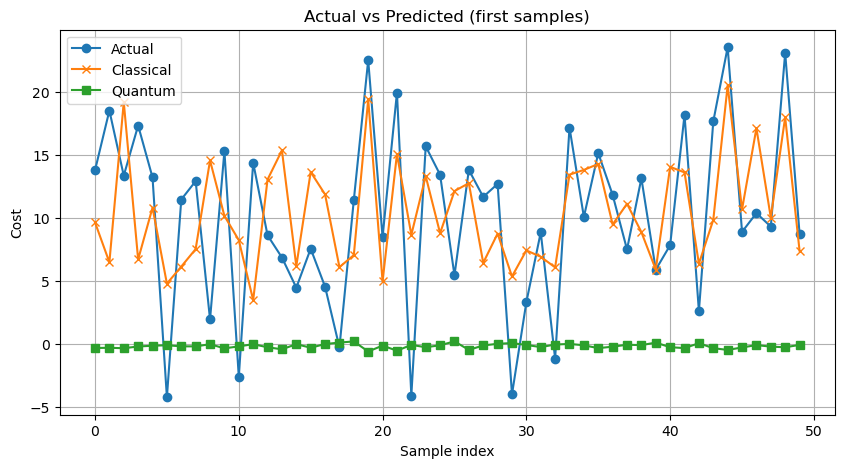

In [49]:
def plot_compare(y_test, pred_classic, pred_quantum, n=50):
    plt.plot(y_test[:n], label="Actual", marker='o')
    plt.plot(pred_classic[:n], label="Classical", marker='x')
    plt.plot(pred_quantum[:n], label="Quantum", marker='s')
    plt.legend()
    plt.xlabel("Sample index")
    plt.ylabel("Cost")
    plt.title("Actual vs Predicted (first samples)")
    plt.grid(True)
    plt.show()

plot_compare(y_test, clf_pred, qml_pred, n=50)


In [50]:
# Save test and predictions to CSV for later analysis
out = pd.DataFrame({
    "actual": y_test,
    "pred_classical": clf_pred,
    "pred_quantum": np.array(qml_pred, dtype=float)
})
out.to_csv("../data/test_predictions.csv", index=False)
print("Saved successfully!")
print("Saved data/test_predictions.csv")


Saved successfully!
Saved data/test_predictions.csv


In [51]:
import sys
print(sys.executable)



C:\Users\KIIT0001\Documents\New folder\envs\py311\python.exe


In [52]:
print("🔍 Cloud Cost Optimization Recommendations:\n")

top_feature = importance_df.iloc[0]["Feature"]

if top_feature == "CPU Hours":
    print("• CPU usage is the main cost driver.")
    print("  Recommendation: Use auto-scaling, right-size VMs, and reduce idle CPU time.")

elif top_feature == "Memory (GB)":
    print("• Memory usage contributes most to cost.")
    print("  Recommendation: Reduce over-provisioned RAM and use memory-optimized instances only when required.")

elif top_feature == "Storage (GB)":
    print("• Storage usage is driving costs.")
    print("  Recommendation: Move infrequently accessed data to cold storage (e.g., Glacier).")

elif top_feature == "Network (GB)":
    print("• Network data transfer is costly.")
    print("  Recommendation: Reduce cross-region traffic and compress data transfers.")


🔍 Cloud Cost Optimization Recommendations:



NameError: name 'importance_df' is not defined